In [1]:
# Pasul 1

import numpy as np
import os
import cv2 as cv
from tqdm import tqdm
from scipy import ndimage
from skimage.feature import hog
from sklearn.svm import LinearSVC, SVC
from copy import deepcopy
import matplotlib.pyplot as plt
import ntpath
import pickle
import pdb
import timeit
import glob

In [2]:
# Pasul 2

ROOT = 'dataset/train/'
TEST_PATH = "C:/Users/Matei/Downloads/CAVA-2022-Tema2/validare/Validare"
characters = ["andy", "louie", "ora", "tommy", "unknown"]
l_window = 36
L_window = 36
dim_hog_cell = 6
num_positive_examples = -1
num_negative_examples = 100000
save_model_path = 'dataset/models/'

# Load SVMs

In [3]:
# Pasul 3

faces = pickle.load(open("dataset/models/final/svm", 'rb'))
andy = pickle.load(open("dataset/models/final/andy", 'rb'))
louie = pickle.load(open("dataset/models/final/louie", 'rb'))
ora = pickle.load(open("dataset/models/final/ora", 'rb'))
tommy = pickle.load(open("dataset/models/final/tommy", 'rb'))
svms = [faces, andy, louie, ora, tommy]

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/models/final/andy2'

# Detect faces

In [ ]:
# Pasul 4

class DetectionResult:
    def __init__(self, detections=None, scores=np.array([]), file_names=np.array([])):
        self.detections = detections
        self.scores = scores
        self.file_names = file_names

In [ ]:
# Pasul 5

def intersection_over_union(box_a, box_b):
    x_min = max(box_a[0], box_b[0])
    y_min = max(box_a[1], box_b[1])
    x_max = min(box_a[2], box_b[2])
    y_max = min(box_a[3], box_b[3])

    inter_area = max(0, x_max - x_min + 1) * max(0, y_max - y_min + 1)

    box_a_area = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    box_b_area = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)

    iou = inter_area / float(box_a_area + box_b_area - inter_area)

    return iou

In [ ]:
# Pasul 6

def non_maximal_suppression(image_detections, image_scores, image_size):
    x_out_of_bounds = np.where(image_detections[:, 2] > image_size[1])[0]
    y_out_of_bounds = np.where(image_detections[:, 3] > image_size[0])[0]

    image_detections[x_out_of_bounds, 2] = image_size[1]
    image_detections[y_out_of_bounds, 3] = image_size[0]
    sorted_indices = np.flipud(np.argsort(image_scores))
    sorted_image_detections = image_detections[sorted_indices]
    sorted_scores = image_scores[sorted_indices]

    is_maximal = np.ones(len(image_detections)).astype(bool)
    iou_threshold = 0.3
    for i in range(len(sorted_image_detections) - 1):
        if is_maximal[i]:
            for j in range(i + 1, len(sorted_image_detections)):
                if is_maximal[j]:
                    if intersection_over_union(sorted_image_detections[i],sorted_image_detections[j]) > iou_threshold:
                        is_maximal[j] = False
                    else:
                        c_x = (sorted_image_detections[j][0] + sorted_image_detections[j][2]) / 2
                        c_y = (sorted_image_detections[j][1] + sorted_image_detections[j][3]) / 2
                        if sorted_image_detections[i][0] <= c_x <= sorted_image_detections[i][2] and \
                                sorted_image_detections[i][1] <= c_y <= sorted_image_detections[i][3]:
                            is_maximal[j] = False
    return sorted_image_detections[is_maximal], sorted_scores[is_maximal]

In [ ]:
# Pasul 7

def save_results(task, path, name="all_faces"):
    detections = np.array(task.detections)
    scores = np.array(task.scores)
    file_names = np.array(task.file_names)

    np.save(path + "detections_" + name + ".npy", detections)
    np.save(path + "scores_" + name + ".npy", scores)
    np.save(path + "file_names_" + name + ".npy", file_names)

In [ ]:
# Pasul 8

def slide_window(initial_size, hog_descriptors, resize_factor, window, w, bias, thresh=0):
    image_detections = [[] for _ in range(len(w))]
    image_scores = [[] for _ in range(len(w))]

    num_cols = initial_size[1] // dim_hog_cell - 1
    num_rows = initial_size[0] // dim_hog_cell - 1
    x_cell_in_template = window[0] // dim_hog_cell - 1
    y_cell_in_template = window[1] // dim_hog_cell - 1

    for y in range(0, num_rows - y_cell_in_template):
        for x in range(0, num_cols - x_cell_in_template):
            descr = hog_descriptors[y:y + y_cell_in_template, x:x + x_cell_in_template].flatten()
            for idx in range(len(w)):
                score = np.dot(descr, w[idx])[0] + bias[idx]

                if score > thresh:
                    x_min = int(x * dim_hog_cell / resize_factor[0])
                    y_min = int(y * dim_hog_cell / resize_factor[1])
                    x_max = int((x * dim_hog_cell + window[0]) / resize_factor[0])
                    y_max = int((y * dim_hog_cell + window[1]) / resize_factor[1])

                    image_detections[idx].append([x_min, y_min, x_max, y_max])
                    image_scores[idx].append(score)

    return image_detections, image_scores

In [ ]:
# Pasul 9

def run(images, svms):
    task1 = DetectionResult()
    task2 = {1: DetectionResult(),  # andy
             2: DetectionResult(),  # louie
             3: DetectionResult(),  # ora
             4: DetectionResult()   # tommy
             }
    w = []
    bias = []
    for svm in svms:
        w.append(svm.coef_.T)
        bias.append(svm.intercept_[0])

    for i in range(len(images)):
        start_time = timeit.default_timer()
        print('Process image with index %d/%d..' % (i, len(images)))
        initial_img = cv.imread(images[i], cv.IMREAD_GRAYSCALE)

        image_scores = [[] for _ in range(len(svms))]
        image_detections = [[] for _ in range(len(svms))]
        resize_factor = (1.1, 1.3)

        while resize_factor[0] > 0 and resize_factor[1] > 0:
            img = cv.resize(initial_img, (0, 0), fx=resize_factor[0], fy=resize_factor[1])

            if img.shape[0] < l_window or img.shape[1] < l_window:
                break

            hog_descriptors = hog(img, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations=18,
                                    cells_per_block=(2, 2), feature_vector=False)

            d, s = slide_window(img.shape, hog_descriptors, resize_factor, (l_window, l_window), w, bias)
            for idx in range(len(svms)):
                image_detections[idx].extend(d[idx])
                image_scores[idx].extend(s[idx])

            # reverse ratio
            img = cv.resize(initial_img, (0, 0), fx=resize_factor[1], fy=resize_factor[0])

            if img.shape[0] < l_window or img.shape[1] < l_window:
                break

            hog_descriptors = hog(img, pixels_per_cell=(dim_hog_cell, dim_hog_cell), orientations=18,
                                    cells_per_block=(2, 2), feature_vector=False)

            rev_factor = resize_factor[1], resize_factor[0]
            d, s = slide_window(img.shape, hog_descriptors, rev_factor, (l_window, l_window), w, bias)
            for idx in range(len(svms)):
                image_detections[idx].extend(d[idx])
                image_scores[idx].extend(s[idx])

            resize_factor = (resize_factor[0] * 0.98, resize_factor[1] * 0.98)


        if len(image_scores) > 0:
            for idx in range(len(svms)):
                image_detections[idx], image_scores[idx] = non_maximal_suppression(
                    np.array(image_detections[idx]),
                    np.array(image_scores[idx]),
                    initial_img.shape
                )

        if len(image_scores) > 0:
            short_name = ntpath.basename(images[i])

            if task1.detections is None:
                task1.detections = image_detections[0]
            else:
                task1.detections = np.concatenate((task1.detections, image_detections[0]))
            task1.scores = np.append(task1.scores, image_scores[0])
            image_names = [short_name for _ in range(len(image_scores[0]))]
            task1.file_names = np.append(task1.file_names, image_names)

            for idx in range(1, len(svms)):
                if task2[idx].detections is None:
                    task2[idx].detections = image_detections[idx]
                else:
                    task2[idx].detections = np.concatenate((task2[idx].detections, image_detections[idx]))
                task2[idx].scores = np.append(task2[idx].scores, image_scores[idx])
                image_names = [short_name for _ in range(len(image_scores[idx]))]
                task2[idx].file_names = np.append(task2[idx].file_names, image_names)

        end_time = timeit.default_timer()
        print('Time of processing the image with index %d/%d is %f sec.'
                % (i, len(images), end_time - start_time))

    return task1, task2

In [ ]:
# Pasul 10

image_names = os.listdir(TEST_PATH)
image_names = [TEST_PATH + "/" + name for name in image_names]
task1, task2 = run(image_names, svms)

# Save results

In [ ]:
# Pasul 11

save_root = "dataset/results/"

# task 1
np.save(save_root + "task1/" + "detections_all_faces.npy", task1.detections)
np.save(save_root + "task1/" + "scores_all_faces.npy", task1.scores)
np.save(save_root + "task1/" + "file_names_all_faces.npy", task1.file_names)

# task 2
for idx, character in enumerate(characters[:-1]):
    np.save(save_root + "task2/" + "detections_" + character + ".npy", task2[idx + 1].detections)
    np.save(save_root + "task2/" + "scores_" + character + ".npy", task2[idx + 1].scores)
    np.save(save_root + "task2/" + "file_names_" + character + ".npy", task2[idx + 1].file_names)

# Visualization part -- do not run

In [40]:
def show_detections_without_ground_truth(detections, scores, file_names):
    test_images_path = os.path.join(TEST_PATH, '*.jpg')
    test_files = glob.glob(test_images_path)

    for test_file in test_files:
        image = cv.imread(test_file)
        short_file_name = ntpath.basename(test_file)
        indices_detections_current_image = np.where(file_names == short_file_name)
        current_detections = detections[indices_detections_current_image]
        current_scores = scores[indices_detections_current_image]

        for idx, detection in enumerate(current_detections):
            if scores[idx] > 1:
                cv.rectangle(image, (detection[0], detection[1]), (detection[2], detection[3]), (0, 0, 255), thickness=1)
                cv.putText(image, 'score:' + str(current_scores[idx])[:4], (detection[0], detection[1]),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        cv.imshow('image', np.uint8(image))
        cv.waitKey(0)

In [41]:
show_detections_without_ground_truth(task1.detections, task1.scores, task1.file_names)

KeyboardInterrupt: 

In [42]:
def compute_average_precision(rec, prec):
    # functie adaptata din 2010 Pascal VOC development kit
    m_rec = np.concatenate(([0], rec, [1]))
    m_pre = np.concatenate(([0], prec, [0]))
    for i in range(len(m_pre) - 1, -1, 1):
        m_pre[i] = max(m_pre[i], m_pre[i + 1])
    m_rec = np.array(m_rec)
    i = np.where(m_rec[1:] != m_rec[:-1])[0] + 1
    average_precision = np.sum((m_rec[i] - m_rec[i - 1]) * m_pre[i])
    return average_precision

In [43]:
def eval_detections(detections, scores, file_names):
    ground_truth_file = np.loadtxt(
        "C:/Users/Matei/Downloads/CAVA-2022-Tema2/validare/task1_gt_validare.txt", dtype='str')

    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], int)

    num_gt_detections = len(ground_truth_detections)
    gt_exists_detection = np.zeros(num_gt_detections)

    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]
    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average precision %.3f' % average_precision)
    plt.savefig(os.path.join("dataset/", 'medium_precision.png'))
    plt.show()

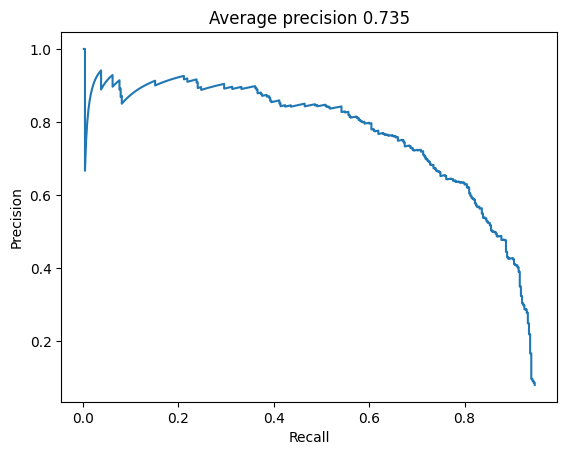

In [44]:
eval_detections(task1.detections, task1.scores, task1.file_names)

In [45]:
def eval_detections_character(detections, scores, file_names, ground_truth_path, character):
    ground_truth_file = np.loadtxt(ground_truth_path, dtype='str')
    ground_truth_file_names = np.array(ground_truth_file[:, 0])
    ground_truth_detections = np.array(ground_truth_file[:, 1:], int)

    num_gt_detections = len(ground_truth_detections)
    gt_exists_detection = np.zeros(num_gt_detections)

    sorted_indices = np.argsort(scores)[::-1]
    file_names = file_names[sorted_indices]

    detections = detections[sorted_indices]

    num_detections = len(detections)
    true_positive = np.zeros(num_detections)
    false_positive = np.zeros(num_detections)
    duplicated_detections = np.zeros(num_detections)

    for detection_idx in range(num_detections):
        indices_detections_on_image = np.where(ground_truth_file_names == file_names[detection_idx])[0]

        gt_detections_on_image = ground_truth_detections[indices_detections_on_image]
        bbox = detections[detection_idx]
        max_overlap = -1
        index_max_overlap_bbox = -1
        for gt_idx, gt_bbox in enumerate(gt_detections_on_image):
            overlap = intersection_over_union(bbox, gt_bbox)
            if overlap > max_overlap:
                max_overlap = overlap
                index_max_overlap_bbox = indices_detections_on_image[gt_idx]

        if max_overlap >= 0.3:
            if gt_exists_detection[index_max_overlap_bbox] == 0:
                true_positive[detection_idx] = 1
                gt_exists_detection[index_max_overlap_bbox] = 1
            else:
                false_positive[detection_idx] = 1
                duplicated_detections[detection_idx] = 1
        else:
            false_positive[detection_idx] = 1

    cum_false_positive = np.cumsum(false_positive)
    cum_true_positive = np.cumsum(true_positive)

    rec = cum_true_positive / num_gt_detections
    prec = cum_true_positive / (cum_true_positive + cum_false_positive)
    average_precision = compute_average_precision(rec, prec)
    plt.plot(rec, prec, '-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(character + ' faces: average precision %.3f' % average_precision)
    plt.savefig('precizie_medie_' + character + '.png')
    plt.show()

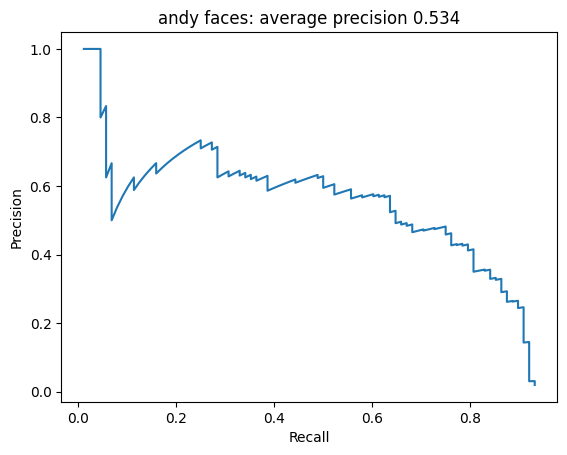

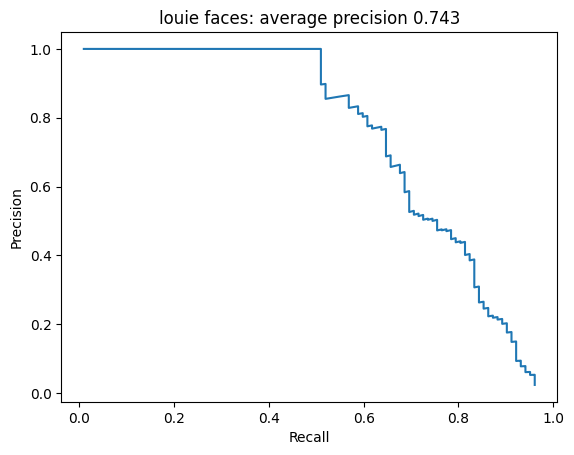

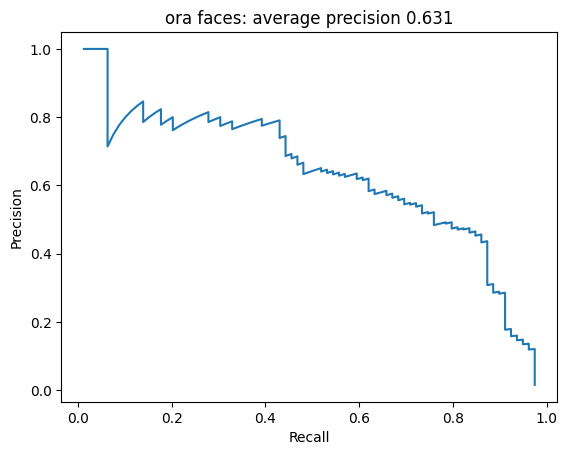

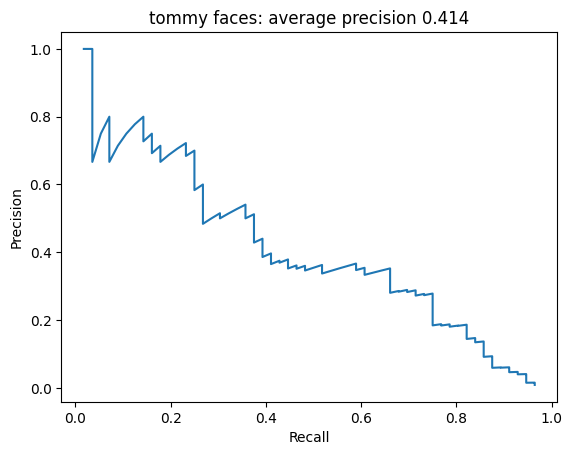

In [46]:
idx = 1
root_path = "C:/Users/Matei/Downloads/CAVA-2022-Tema2/validare/"
for character in characters[:-1]:
    gt_path = root_path + "task2_" + character + "_gt_validare.txt"
    eval_detections_character(task2[idx].detections, task2[idx].scores, task2[idx].file_names, gt_path, character)
    idx += 1

 # Get strongly negative examples

In [ ]:
def get_detections(path, low_limit, high_limit):
    image_names = os.listdir(path)
    image_names = [path + "/" + name for name in image_names]
    detections, scores, file_names = run(image_names[low_limit:high_limit])
    return detections, scores, file_names

In [ ]:
def save_strong_negatives(character, detections, filename, count):
    root = "C:/Users/Matei/Downloads/CAVA-2022-Tema2/antrenare/"
    save_path = "dataset/train/negatives/strong/"
    path = root + character + "_annotations.txt"
    annotations_file = open(path)
    annotations = annotations_file.read().splitlines()
    annotations_file.close()
    annotations = [annotation.split() for annotation in annotations]

    for idx, detection in enumerate(detections):
        name = filename[idx]
        faces = []
        for annotation in annotations:
            if annotation[0] == name:
                faces.append((int(annotation[1]), int(annotation[2]), int(annotation[3]), int(annotation[4])))
        intersections = [intersection_over_union(detection, face) for face in faces]
        if all(intersection < 0.3 for intersection in intersections):
            img = cv.imread(root + character + "/" + name)
            false_positive = img[detection[1]:detection[3], detection[0]:detection[2]]
            count += 1
            cv.imwrite(save_path + str(count) + ".jpg", false_positive)
    return count

In [ ]:
train = "C:/Users/Matei/Downloads/CAVA-2022-Tema2/antrenare/"
detections = []
scores = []
file_names = []
count = 0
for i in range(0, 11):
    for character in characters[:4]:
        path = train + character
        task1 = get_detections(path, 10 * (i - 1), 10 * i)
        count = save_strong_negatives(character, task1.detections, task1.file_names, count)